In [ ]:
#library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
import time

# Dataset

Using the white wine quality dataset - available at https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv


In [ ]:
wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', sep=';')
# Selecting two of the seven  available classes arbitrarily -
#Picked 5 and 7 because good number of samples, relatively balanced between the two classes, and the classes are close enough in terms of similarity (from experience in 786 with the dataset) that it will give the classifier some complexity
wine = wine[(wine['quality'] == 5) | (wine['quality'] == 7)]
X = wine.drop('quality', axis=1) #separating data and labels
y = wine['quality']
y = y.apply(lambda label: 1 if label == 7 else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) #split 25% train, 75% test data


In [ ]:
wine["quality"].value_counts()

5    1457
7     880
Name: quality, dtype: int64

In [ ]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 10 to 4896
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         2337 non-null   float64
 1   volatile acidity      2337 non-null   float64
 2   citric acid           2337 non-null   float64
 3   residual sugar        2337 non-null   float64
 4   chlorides             2337 non-null   float64
 5   free sulfur dioxide   2337 non-null   float64
 6   total sulfur dioxide  2337 non-null   float64
 7   density               2337 non-null   float64
 8   pH                    2337 non-null   float64
 9   sulphates             2337 non-null   float64
 10  alcohol               2337 non-null   float64
 11  quality               2337 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 237.4 KB


In [ ]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
10,8.1,0.27,0.41,1.45,0.033,11.0,63.0,0.9908,2.99,0.56,12.0,5
11,8.6,0.23,0.40,4.20,0.035,17.0,109.0,0.9947,3.14,0.53,9.7,5
12,7.9,0.18,0.37,1.20,0.040,16.0,75.0,0.9920,3.18,0.63,10.8,5
13,6.6,0.16,0.40,1.50,0.044,48.0,143.0,0.9912,3.54,0.52,12.4,7
14,8.3,0.42,0.62,19.25,0.040,41.0,172.0,1.0002,2.98,0.67,9.7,5


#KNN Classifier

10-fold cross validation

In [ ]:
k_range = range(1, 100) #vary k values from 1 to 100
k_scores = [] #create empty list to hold scores from cross val
start = time.time() # start timing the training process
for k in k_range: #go through each value of k, do CV, get accuracy scores, then pick the k with the best accuracy score
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=KFold(shuffle=True, n_splits=10), scoring='accuracy')
    k_scores.append(scores.mean())
best_k = k_range[k_scores.index(max(k_scores))]
print("Best value of K:", best_k)
knn = KNeighborsClassifier(n_neighbors=best_k)#train the classifier with the best k value
knn.fit(X_train, y_train)
end = time.time() # end timing the training process
print("Training time:", end - start, "seconds")

Best value of K: 1
Training time: 14.984583139419556 seconds


Text(0, 0.5, 'Accuracy')

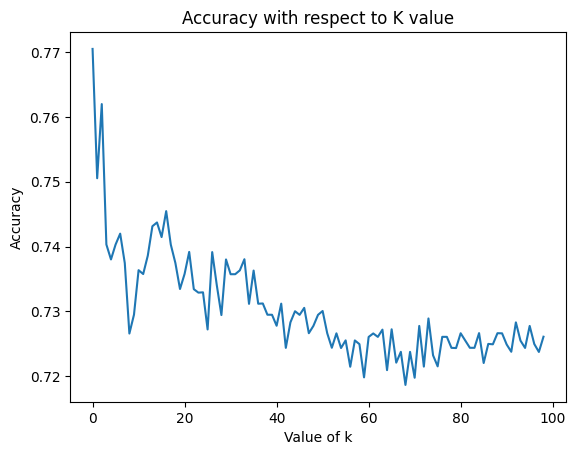

In [ ]:
plt.plot(k_scores) #illustrate the accuracy with respect to value of k
plt.title("Accuracy with respect to K value")
plt.xlabel('Value of k')
plt.ylabel("Accuracy")

In [ ]:
start = time.time() #start timing for test computation
accuracy = knn.score(X_test, y_test)
end = time.time() # end timing
print("Testing time:", end - start, "seconds")
print("Accuracy:", accuracy)

Testing time: 0.02864980697631836 seconds
Accuracy: 0.8102564102564103


In [ ]:
y_pred = knn.predict(X_test)
cm = confusion_matrix(y_test, y_pred) #plot the confusion matrix
df_cm = pd.DataFrame(cm)
df_cm.columns = ['Predicted Quality 5', 'Predicted Quality 7']
df_cm.index = ['True Quality 5', 'True Quality 7']
df_cm

,Predicted Quality 5,Predicted Quality 7
True Quality 5,300,56
True Quality 7,55,174


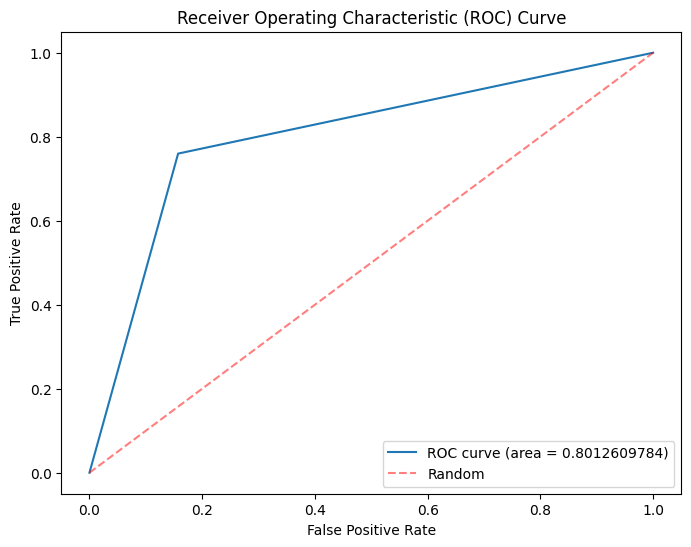

In [ ]:
y_probs = knn.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs) #get the probabilities false positives and true positives
roc_auc = auc(fpr, tpr) #calculate the area under the curve
plt.figure(figsize=(8, 6)) #plot the ROC, true positive with respect to true positive rate
plt.plot(fpr, tpr, label='ROC curve (area = %0.10f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random', alpha=0.5) #plot straight line, representing worst possible classification (completely random)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#AdaBoost

In [ ]:
# re-initialize data, to make sure not re-using variables from KNN
wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', sep=';')
wine = wine[(wine['quality'] == 5) | (wine['quality'] == 7)]
X = wine.drop('quality', axis=1)
y = wine['quality']
y = y.apply(lambda label: 1 if label == 7 else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
estimator_range = range(10, 201, 10) #cross val to get optimal number of decision trees, same process as kNN
adaboost_scores = []
start = time.time()
for n_estimators in estimator_range:
    ada_boost = AdaBoostClassifier(n_estimators=n_estimators, random_state=42) # for each estimator number, do 10 fold cross validation, take the mean score and select the best one
    scores = cross_val_score(ada_boost, X_train, y_train, cv=KFold(shuffle=True, n_splits=10), scoring='accuracy')
    adaboost_scores.append(np.mean(scores))
best_n_estimators = estimator_range[np.argmax(adaboost_scores)]
print("Best n_estimators:", best_n_estimators)
adaboost_classifier = AdaBoostClassifier(n_estimators=best_n_estimators, random_state=42) #train the adaboost classifer on training data, with the most optimal number of decision trees
adaboost_classifier.fit(X_train, y_train)
end = time.time()
print("Training time:", end - start, "seconds")


Best n_estimators: 140
Training time: 88.03682923316956 seconds


Text(0, 0.5, 'Accuracy')

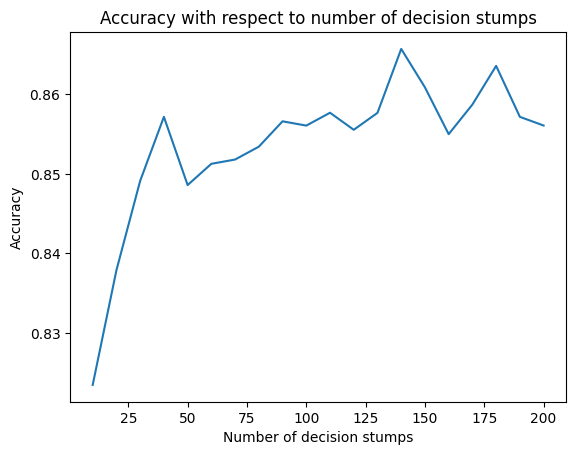

In [ ]:
plt.plot(estimator_range, adaboost_scores)
plt.title("Accuracy with respect to number of decision stumps")
plt.xlabel('Number of decision stumps')
plt.ylabel("Accuracy")

In [ ]:
start = time.time()
y_pred = adaboost_classifier.predict(X_test) #evaluate the trained adaboost classifer on test data
end = time.time()
accuracy = accuracy_score(y_test, y_pred)
print("Testing time:", end - start, "seconds")
print('Accuracy: {:.10f}'.format(accuracy_score(y_test, y_pred)))

Testing time: 0.02719283103942871 seconds
Accuracy: 0.8675213675


In [ ]:
cm = confusion_matrix(y_test, y_pred) #establish the confusion matrix based on test data
df_cm = pd.DataFrame(cm)
df_cm.columns = ['Predicted Quality 5', 'Predicted Quality 7']
df_cm.index = ['True Quality 5', 'True Quality 7']
df_cm

,Predicted Quality 5,Predicted Quality 7
True Quality 5,258,22
True Quality 7,40,148


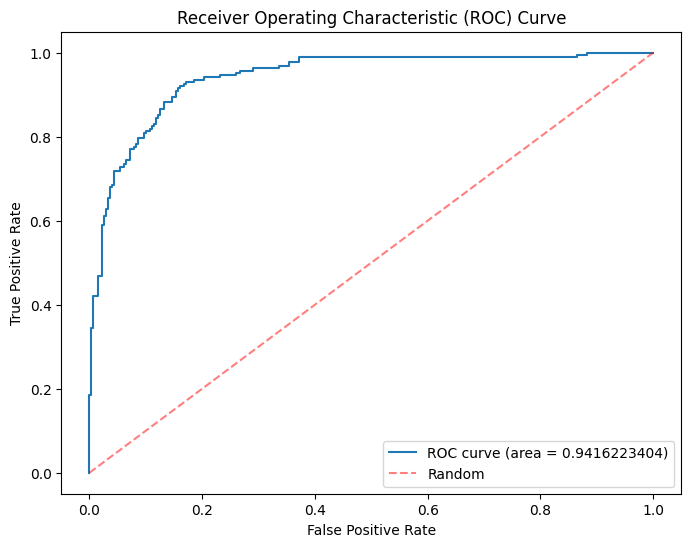

In [ ]:
y_probs = adaboost_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs) #get the true and false positive rates for the ROC curve plotting
roc_auc = auc(fpr, tpr) #calc area under curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.10f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random', alpha=0.5) #random
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# SVM

In [ ]:
# re-initialize data, to make sure not re-using variables from KNN or adaboost
wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', sep=';')
wine = wine[(wine['quality'] == 5) | (wine['quality'] == 7)]
X = wine.drop('quality', axis=1)
y = wine['quality']
y = y.apply(lambda label: 1 if label == 7 else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
gammas = range(1,100) # cross validation for gamma, which governs the standard deviation of the rbf kernel
# from documentation gamma = 1 / (2 * sigma^2), where sigma is the standard deviation: gamma inversely proporitonal  to standard deviation
# do a similar process as KNN and adaboost, do 10-fold for each gamma, take the average accuracy score, and select the best gamma value
accuracy_scores = []
start = time.time()
for gamma in gammas:
    svm = SVC(kernel='rbf', gamma=gamma, random_state=42)
    accuracy_scores.append(np.mean(cross_val_score(svm, X_train, y_train, cv=KFold(shuffle=True, n_splits=10), scoring='accuracy')))
best_gamma = gammas[np.argmax(accuracy_scores)]
print("Optimal gamma: {}".format(best_gamma))
svm_classifier = SVC(kernel='rbf', gamma=best_gamma, random_state=42) #train an svm classifer on the gamma with the best results
svm_classifier.fit(X_train, y_train)
end = time.time()
print("Training time:", end - start, "seconds")


Optimal gamma: 39
Training time: 227.54222655296326 seconds


Text(0, 0.5, 'Gamma')

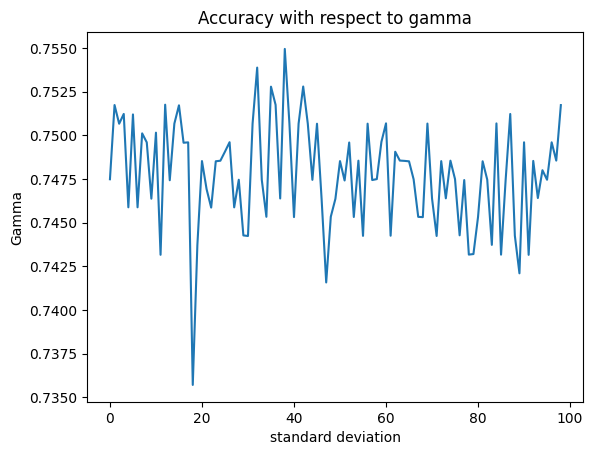

In [ ]:
plt.plot(accuracy_scores)
plt.title("Accuracy with respect to gamma")
plt.xlabel('standard deviation')
plt.ylabel("Gamma")

In [ ]:
#trying logarithmic scale for the standard deviation of the kernel
# capture more from the smaller value range, as from linear evaluation, the results are rather constant from 1-100, ableit with a lot of fluctuations
gammas = [0.001, 0.01, 0.1, 1, 10, 100, 1000] #testing only 7 vlaues, saves more time from linear
accuracy_scores = []
start = time.time()
for gamma in gammas:
    svm = SVC(kernel='rbf', gamma=gamma, random_state=42)
    accuracy_scores.append(np.mean(cross_val_score(svm, X_train, y_train, cv=KFold(shuffle=True, n_splits=10), scoring='accuracy')))
best_gamma = gammas[np.argmax(accuracy_scores)]
print("Optimal gamma: {}".format(best_gamma))
svm_classifier = SVC(kernel='rbf', gamma=best_gamma, random_state=42, probability=True) #train classifier
svm_classifier.fit(X_train, y_train)
end = time.time()
print("Training time:", end - start, "seconds")

Optimal gamma: 0.1
Training time: 14.199738502502441 seconds


Text(0, 0.5, 'Accuracy')

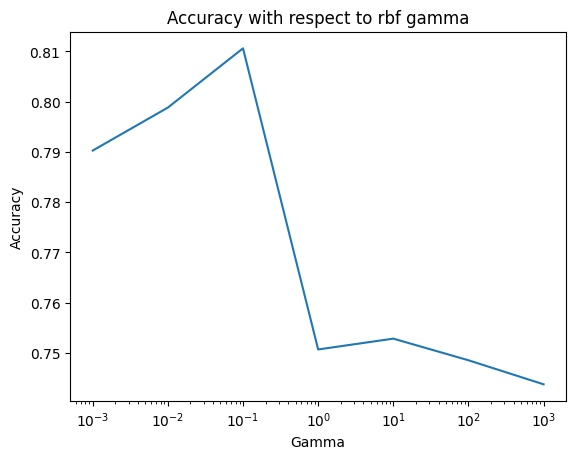

In [ ]:
plt.plot(gammas, accuracy_scores) #better results than conventional linear classifiers, clear indication that 0.1 is best
plt.xscale("log")
plt.title("Accuracy with respect to rbf gamma")
plt.xlabel('Gamma')
plt.ylabel("Accuracy")

In [ ]:
start = time.time()
y_pred = svm_classifier.predict(X_test) #eval classifier
end = time.time()
accuracy = accuracy_score(y_test, y_pred)
print("Testing time:", end - start, "seconds")
print('Accuracy: {:.10f}'.format(accuracy_score(y_test, y_pred)))

Testing time: 0.061023712158203125 seconds
Accuracy: 0.8247863248


In [ ]:
cm = confusion_matrix(y_test, y_pred) #build confusion matrix
df_cm = pd.DataFrame(cm)
df_cm.columns = ['Predicted Quality 5', 'Predicted Quality 7']
df_cm.index = ['True Quality 5', 'True Quality 7']
df_cm

,Predicted Quality 5,Predicted Quality 7
True Quality 5,258,22
True Quality 7,60,128


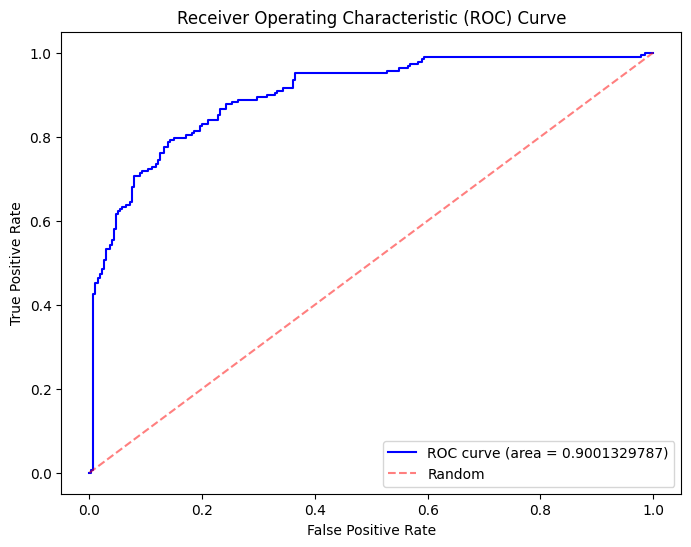

In [ ]:
y_probs = svm_classifier.predict_proba(X_test)[:, 1] #build roc from true & false positive rates
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.10f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random', alpha=0.5) #random
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()